# Trabajo práctico nº 1

### Paquetes utilizados y otras configuraciones

In [112]:
# Paquetes empleados

import pandas as pd
# import unicodedata
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import matplotlib.ticker as mtick # para manipular etiquetas de eje



# from scipy.stats import ttest_ind # prueba t de student (complemento)

In [113]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'Times', 'DejaVu Serif', 'Computer Modern Roman']

# Ajustar el tamaño de fuente global
plt.rcParams['font.size'] = 14

## Parte I

### Operaciones preeliminares

Levantamos la base de datos resultante en el TP 1, según la cual se unieron las bases de EPH de individuos de los trimestres 1 de 2005 junto con la de 2025.

Se recuperan variables necesarias para el presente TP 2, solicitadas en el TP 1

In [129]:
# r"C:\Trabajos\Maestria\2 año\Tercer trimestre\Taller de programación\BigDataUBA-Grupo1\BigDataUBA-Grupo1\TP2\basei_unida.xlsx" # path de Fran

base = pd.read_excel(r"C:\Trabajos\Maestria\2 año\Tercer trimestre\Taller de programación\BigDataUBA-Grupo1\BigDataUBA-Grupo1\TP2\basei_unida.xlsx") 

In [115]:
base.columns # se muestran las columnas de la base cargada

Index(['CODUSU', 'NRO_HOGAR', 'COMPONENTE', 'H15', 'ANO4', 'TRIMESTRE',
       'REGION', 'PONDERA', 'CH03', 'CH04', 'CH06', 'CH07', 'CH08', 'NIVEL_ED',
       'ESTADO', 'CAT_INAC', 'IPCF', 'CH10', 'CH12', 'CH13', 'CH14', 'CH15',
       'PP02H', 'PP02I', 'PP10A', 'PP3E_TOT', 'PP3F_TOT', 'T_VI', 'ITF',
       'PP02E', 'PERIODO'],
      dtype='object')

In [116]:
# Variable asociada a si el individuo respondió o no la encuesta de ingresos totales familiares

base['respondieron'] = base['ITF'] > 0 # 1 si respondieron, 0 si no respondieron

# Variable de adultos equivalentes según INDEC

base = base.assign(
    adult_eq = np.select(
        [
            base.CH06 < 1,
            base.CH06 == 1,
            base.CH06 == 2,
            base.CH06 == 3,
            base.CH06 == 4,
            base.CH06 == 5,
            base.CH06 == 6,
            base.CH06 == 7,
            base.CH06 == 8,
            base.CH06 == 9,
            base.CH06 == 10,
            base.CH06 == 11,
            base.CH06 == 12,
            base.CH06 == 13,
            base.CH06 == 14,
            base.CH06 == 15,
            base.CH06 == 16,
            base.CH06 == 17,
            base.CH06.between(18,29),
            base.CH06.between(30,45),
            base.CH06.between(46,60),
            base.CH06.between(61,75),
            base.CH06 > 75
        ],
        [
            0.35,
            0.37,
            0.46,
            0.51,
            0.55,
            0.60,
            0.64,
            0.66,
            0.68,
            0.69,
            np.where(base.CH04==1,0.79,0.70),
            np.where(base.CH04==1,0.82,0.72),
            np.where(base.CH04==1,0.85,0.74),
            np.where(base.CH04==1,0.90,0.76),
            np.where(base.CH04==1,0.96,0.76),
            np.where(base.CH04==1,1.00,0.77),
            np.where(base.CH04==1,1.03,0.77),
            np.where(base.CH04==1,1.04,0.77),
            np.where(base.CH04==1,1.02,0.76),
            1.00,
            np.where(base.CH04==1,1.00,0.76),
            np.where(base.CH04==1,0.83,0.67),
            np.where(base.CH04==1,0.74,0.63)
        ],
        default=np.nan
    )
)

# Variable de adultos equivalentes por hogar 
base['ad_equiv_hogar'] = base.groupby('CODUSU')['adult_eq'].transform('sum')

# Variable de ingreso necesario para no ser pobre

cbt_por_año = {2005: 205.07, 2025: 365_177} # canasta requerida por año

base['ingreso_necesario'] = base.apply(
    lambda row: row['ad_equiv_hogar'] * cbt_por_año.get(row['ANO4'], 0),
    axis=1
)

del cbt_por_año # borramos variable auxiliar

# Variable dummy de pobreza (1 si es pobre, 0 si no lo es)
base['pobre'] = (base['ITF'] < base['ingreso_necesario']).astype(int)

### Consigna 1

In [117]:
# Variable de edad al cuadrado
base['edad2'] = base['CH06']^2 

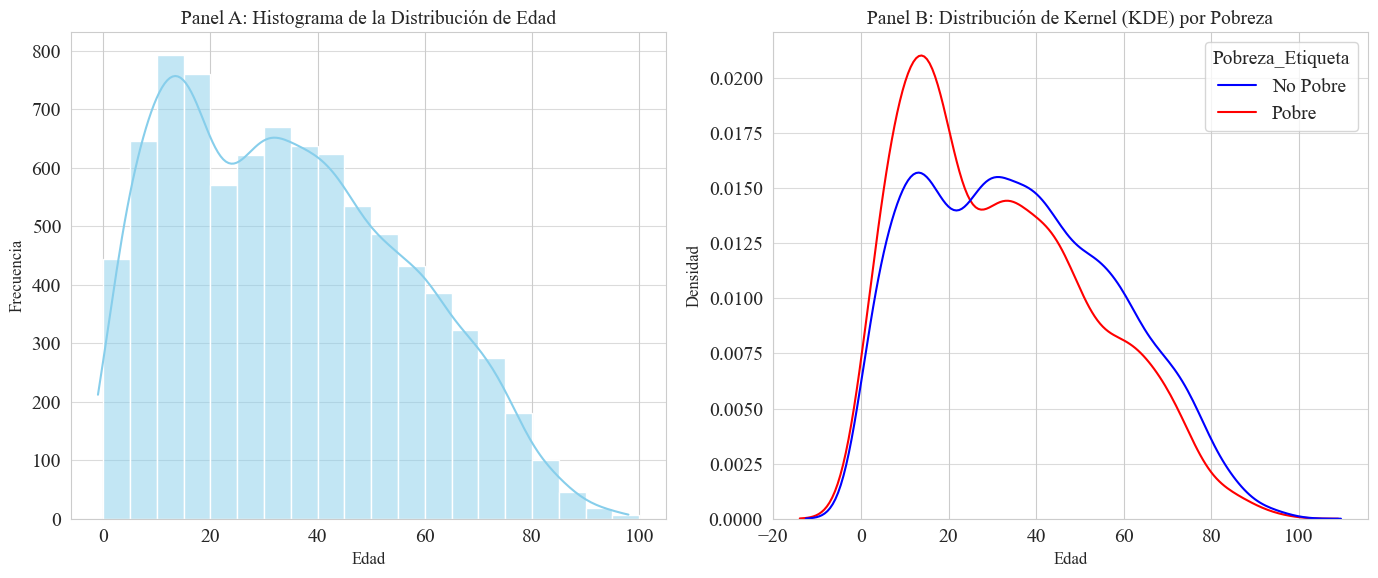

In [118]:

# Configuración del lienzo para dos paneles (1 fila, 2 columnas)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Panel A: Histograma de Edad (Distribución General) ---
sns.histplot(
    data=base,
    x='CH06',
    bins=range(0, base['CH06'].max() + 5, 5), # Agrupación por tramos de 5 años
    kde=True,
    ax=axes[0],
    color='skyblue'
)
axes[0].set_title('Panel A: Histograma de la Distribución de Edad', fontsize=14)
axes[0].set_xlabel('Edad', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].grid(axis='y', alpha=0.7)

# --- Panel B: Distribución de Kernel (KDE) por Condición de Pobreza ---
# Mapear la variable 'pobre' para una mejor leyenda
base['Pobreza_Etiqueta'] = base['pobre'].map({0: 'No Pobre', 1: 'Pobre'})

sns.kdeplot(
    data=base,
    x='CH06',
    hue='Pobreza_Etiqueta', # Separar la distribución por 'pobre'
    fill=False,
    common_norm=False,
    ax=axes[1],
    palette={'Pobre': 'red', 'No Pobre': 'blue'}
)
axes[1].set_title('Panel B: Distribución de Kernel (KDE) por Pobreza', fontsize=14)
axes[1].set_xlabel('Edad', fontsize=12)
axes[1].set_ylabel('Densidad', fontsize=12)
axes[1].grid(axis='y', alpha=0.7)

# Ajustar diseño y mostrar el gráfico
plt.tight_layout()
plt.show()

# Eliminar la columna temporal
del base['Pobreza_Etiqueta']

### Consigna 2

Para resolver la consigna, se traen las bases EPH originales de modo de incorporar las variables:
- CH12 (nivel educativo más alto alcanzado);
- CH13 (finalizó dicho nivel); y
- CH14 (último año aprobado)

In [119]:
# ==============================================================================
# 1. CREACIÓN DE LA VARIABLE 'educ' (AÑOS DE EDUCACIÓN)
# ==============================================================================

# Definir las condiciones y los valores correspondientes
# CH13: 1=Sí finalizó el nivel, 2=No finalizó el nivel
# CH12: Nivel más alto alcanzado (1=Jardín, 2=Primaria, 3=EGB, 4=Secundaria, 5=Polimodal, 6=Terciario, 7=Universitario, 8=Posgrado, 9=Educación especial)
# CH14: Último año/grado aprobado (0=Ninguno/inicial, 1=1er año, 2=2do año, etc.)

condiciones = [
    # -------------------------------------------------------------------------
    # Casos Especiales (educ = 0)
    # -------------------------------------------------------------------------
    (base['CH10'] == 3),                         # Nunca asistió
    (base['CH06'] < 2),                          # Menores de dos años
    (base['CH12'] == 9),                         # Educación especial
    (base['CH13'] == 2) & (base['CH12'] == 1),   # Jardín/preescolar incompleto

    # -------------------------------------------------------------------------
    # Casos INCOMPLETOS (ch13 == 2) - Los años de educación dependen del ch14 (año aprobado)
    # -------------------------------------------------------------------------
    # Primaria (6 años de duración)
    (base['CH13'] == 2) & (base['CH12'] == 2) & (base['CH14'].isin(range(0, 7))),
    # EGB (9 años de duración)
    (base['CH13'] == 2) & (base['CH12'] == 3) & (base['CH14'].isin(range(0, 9))),
    # Secundaria (5 años de duración, años: 8 a 12)
    (base['CH13'] == 2) & (base['CH12'] == 4) & (base['CH14'].isin(range(0, 6))),
    # Polimodal (3 años de duración, años: 10 a 12)
    (base['CH13'] == 2) & (base['CH12'] == 5) & (base['CH14'].isin(range(0, 4))),
    # Terciario (Suponemos 3 años completo, años: 13 a 15)
    (base['CH13'] == 2) & (base['CH12'] == 6) & (base['CH14'].isin(range(0, 3))),
    (base['CH13'] == 2) & (base['CH12'] == 6) & (base['CH14'] >= 2) & (base['CH14'] < 98), # CH14 >= 2 (2+ años aprobados)
    # Universitario (Suponemos 6 años completo, años: 13 a 18)
    (base['CH13'] == 2) & (base['CH12'] == 7) & (base['CH14'].isin(range(0, 6))),
    (base['CH13'] == 2) & (base['CH12'] == 7) & (base['CH14'] >= 5) & (base['CH14'] < 98), # CH14 >= 5 (5+ años aprobados)
    # Posgrado (Suponemos 4 años completo, años: 19 a 22)
    (base['CH13'] == 2) & (base['CH12'] == 8) & (base['CH14'].isin(range(0, 4))),
    (base['CH13'] == 2) & (base['CH12'] == 8) & (base['CH14'] >= 3) & (base['CH14'] < 98), # CH14 >= 3 (3+ años aprobados)

    # -------------------------------------------------------------------------
    # Casos COMPLETOS (ch13 == 1) - Los años de educación dependen del ch12 (nivel)
    # -------------------------------------------------------------------------
    (base['CH13'] == 1) & (base['CH12'] == 1),   # Jardín/preescolar completo
    (base['CH13'] == 1) & (base['CH12'] == 2),   # Primaria completa
    (base['CH13'] == 1) & (base['CH12'] == 3),   # EGB completa
    (base['CH13'] == 1) & ((base['CH12'] == 4) | (base['CH12'] == 5)), # Secundaria/Polimodal completo
    (base['CH13'] == 1) & (base['CH12'] == 6),   # Terciario completo (Asume 3 años)
    (base['CH13'] == 1) & (base['CH12'] == 7),   # Universitario completo (Asume 6 años)
    (base['CH13'] == 1) & (base['CH12'] == 8),   # Posgrado completo (Asume 4 años)
]

# Las fórmulas de cálculo para cada condición (en el mismo orden)
# Para los casos INCOMPLETOS, el año de educación es el AÑO BASE + CH14
# Años Base: Primaria(ch12=2) -> 1, EGB(ch12=3) -> 1, Secundaria(ch12=4) -> 8, Polimodal(ch12=5) -> 10, Terciario(ch12=6) -> 13, Universitario(ch12=7) -> 13, Posgrado(ch12=8) -> 19

values = [
    # Casos Especiales (educ = 0)
    0, 0, 0, 0,

    # Primaria Incompleta (1 a 7) - Años: 0+1=1 a 6+1=7. La fórmula es 1 + CH14.
    1 + base['CH14'],

    # EGB Incompleta (1 a 9) - Años: 0+1=1 a 8+1=9. La fórmula es 1 + CH14.
    1 + base['CH14'],

    # Secundaria Incompleta (8 a 13) - Años: 0+8=8 a 5+8=13. La fórmula es 8 + CH14.
    8 + base['CH14'],

    # Polimodal Incompleto (10 a 13) - Años: 0+10=10 a 3+10=13. La fórmula es 10 + CH14.
    10 + base['CH14'],

    # Terciario Incompleto (13 a 15) - Años: 0+13=13 a 2+13=15. La fórmula es 13 + CH14.
    13 + base['CH14'],
    # Terciario Incompleto (CH14 >= 2) - Los años de educación son 13 + 2 = 15 (asumiendo que 98 es missing)
    15,

    # Universitario Incompleto (13 a 18) - Años: 0+13=13 a 4+13=17. La fórmula es 13 + CH14.
    13 + base['CH14'],
    # Universitario Incompleto (CH14 >= 5) - Los años de educación son 13 + 5 = 18 (asumiendo que 98 es missing)
    18,

    # Posgrado Incompleto (19 a 22) - Años: 0+19=19 a 2+19=21. La fórmula es 19 + CH14.
    19 + base['CH14'],
    # Posgrado Incompleto (CH14 >= 3) - Los años de educación son 19 + 3 = 22 (asumiendo que 98 es missing)
    22,

    # Casos COMPLETOS
    1,   # Jardín/preescolar
    8,   # Primaria (7 años de primaria + 1 de jardín)
    11,  # EGB (1 año de jardín + 9 años de EGB - ajustado a 11 según el código original)
    13,  # Secundaria/Polimodal (1 año de jardín + 6 de primaria + 6 de secundaria/polimodal - ajustado a 13)
    16,  # Terciario (13 + 3 años asumidos)
    19,  # Universitario (13 + 6 años asumidos)
    23,  # Posgrado (19 + 4 años asumidos)
]

# Creación de la nueva variable 'educ'
base['educ'] = np.select(condiciones, values, default=np.nan)

# Convertir a entero si no hay NaNs
base['educ'] = base['educ'].astype('Int64')

# ==============================================================================
# 2. ESTADÍSTICA DESCRIPTIVA Y COMENTARIO
# ==============================================================================

descriptives = base['educ'].describe()
print("\nEstadísticas Descriptivas de la variable 'educ' (Años de Educación):\n")
print(descriptives.loc[['mean', 'std', 'min', '50%', 'max']]) # Selecciona las métricas solicitadas

del descriptives # Limpiar variable temporal


Estadísticas Descriptivas de la variable 'educ' (Años de Educación):

mean    10.143596
std       5.08444
min           0.0
50%          11.0
max          23.0
Name: educ, dtype: Float64


### Consigna 3

In [120]:
base.columns

Index(['CODUSU', 'NRO_HOGAR', 'COMPONENTE', 'H15', 'ANO4', 'TRIMESTRE',
       'REGION', 'PONDERA', 'CH03', 'CH04', 'CH06', 'CH07', 'CH08', 'NIVEL_ED',
       'ESTADO', 'CAT_INAC', 'IPCF', 'CH10', 'CH12', 'CH13', 'CH14', 'CH15',
       'PP02H', 'PP02I', 'PP10A', 'PP3E_TOT', 'PP3F_TOT', 'T_VI', 'ITF',
       'PP02E', 'PERIODO', 'respondieron', 'adult_eq', 'ad_equiv_hogar',
       'ingreso_necesario', 'pobre', 'edad2', 'educ'],
      dtype='object')

#### Inspeccionando resultados

In [121]:
base['factor_de_actualizacion'] = np.where(base['ANO4'] == 2005, FACTOR_DEFLACTACION_IPC, 1.0)
base['ingreso_total_familiar'] = base['ITF'] * base['factor_de_actualizacion']
base['ingreso_necesario_act'] = base['ingreso_necesario'] * base['factor_de_actualizacion']

Observaciones fuera del límite (2025): 6
Hogares fuera del límite (2025): 2


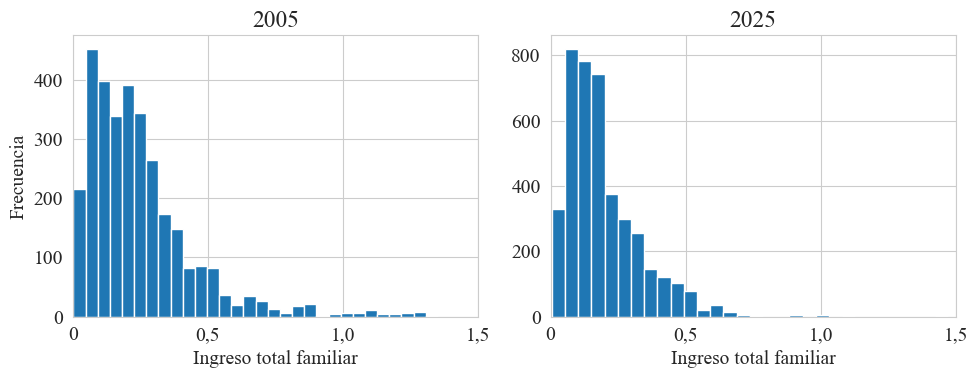

In [122]:

prueba = base[['CODUSU', 'ANO4', 'NRO_HOGAR', 'ITF', 'ingreso_total_familiar']].copy()

# Filtrar valores positivos
prueba = prueba[prueba['ingreso_total_familiar'] > 0]

# Definir límite
limite = 1.5e7

# Detectar outliers de 2025
fuera_2025 = prueba[(prueba['ANO4'] == 2025) & (prueba['ingreso_total_familiar'] > limite)]

print("Observaciones fuera del límite (2025):", len(fuera_2025))
print("Hogares fuera del límite (2025):", fuera_2025['CODUSU'].nunique())

# Datos truncados para graficar
prueba_2025_trim = prueba[(prueba['ANO4'] == 2025) & (prueba['ingreso_total_familiar'] <= limite)]
prueba_2005 = prueba[prueba['ANO4'] == 2005]

# Gráficos comparativos con escala homogénea
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(prueba_2005['ingreso_total_familiar'], bins=30)
axes[0].set_title('2005')
axes[0].set_xlabel('Ingreso total familiar')
axes[0].set_ylabel('Frecuencia')
axes[0].set_xlim(0, 1.5e7)
axes[0].set_xticks([0, 0.5e7, 1e7, 1.5e7])
axes[0].set_xticklabels(['0', '0,5', '1,0', '1,5'])

axes[1].hist(prueba_2025_trim['ingreso_total_familiar'], bins=30)
axes[1].set_title('2025')
axes[1].set_xlabel('Ingreso total familiar')
axes[1].set_xlim(0, 1.5e7)
axes[1].set_xticks([0, 0.5e7, 1e7, 1.5e7])
axes[1].set_xticklabels(['0', '0,5', '1,0', '1,5'])

plt.tight_layout()
plt.show()

del prueba_2025_trim, prueba_2005, prueba, fuera_2025, limite

In [123]:
base.columns

Index(['CODUSU', 'NRO_HOGAR', 'COMPONENTE', 'H15', 'ANO4', 'TRIMESTRE',
       'REGION', 'PONDERA', 'CH03', 'CH04', 'CH06', 'CH07', 'CH08', 'NIVEL_ED',
       'ESTADO', 'CAT_INAC', 'IPCF', 'CH10', 'CH12', 'CH13', 'CH14', 'CH15',
       'PP02H', 'PP02I', 'PP10A', 'PP3E_TOT', 'PP3F_TOT', 'T_VI', 'ITF',
       'PP02E', 'PERIODO', 'respondieron', 'adult_eq', 'ad_equiv_hogar',
       'ingreso_necesario', 'pobre', 'edad2', 'educ',
       'factor_de_actualizacion', 'ingreso_total_familiar',
       'ingreso_necesario_act'],
      dtype='object')

Registros fuera del límite por año:
ANO4
2025    6
dtype: int64

Porcentaje sobre total por año:
ANO4
2005         NaN
2025    0.111961
dtype: float64


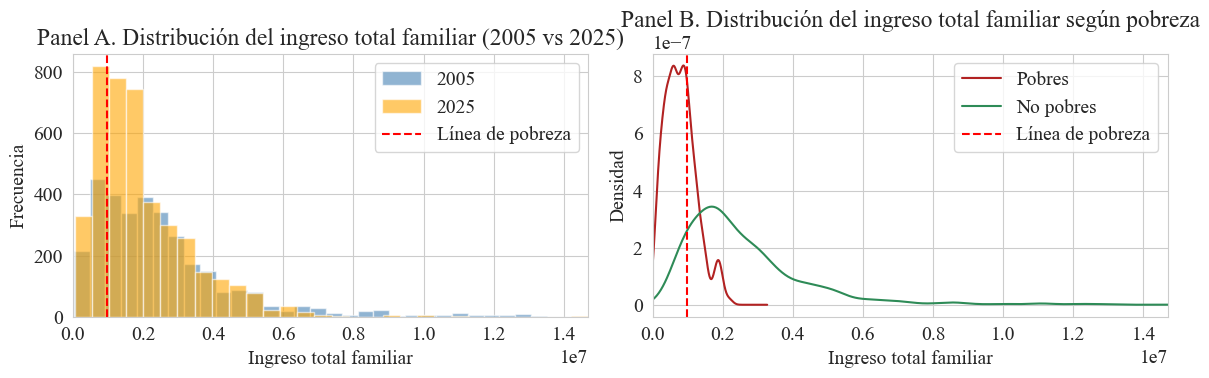

In [124]:
base_filtrada = base[(base['ingreso_total_familiar'] > 0) & 
                     (base['ingreso_total_familiar'] < 1.5e7)]

fuera = base[base['ingreso_total_familiar'] >= 1.5e7]
conteo_fuera = fuera.groupby('ANO4').size()
porcentaje_fuera = (conteo_fuera / base.groupby('ANO4').size()) * 100

print("Registros fuera del límite por año:")
print(conteo_fuera)
print("\nPorcentaje sobre total por año:")
print(porcentaje_fuera)

# Separar por año
base_2005 = base_filtrada[base_filtrada['ANO4'] == 2005]
base_2025 = base_filtrada[base_filtrada['ANO4'] == 2025]

x_max = max(base_2005['ingreso_total_familiar'].max(),
            base_2025['ingreso_total_familiar'].max())

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Panel A: Histogramas comparativos por año
axes[0].hist(base_2005['ingreso_total_familiar'], bins=30, color='steelblue', alpha=0.6, label='2005')
axes[0].hist(base_2025['ingreso_total_familiar'], bins=30, color='orange', alpha=0.6, label='2025')
axes[0].axvline(base_filtrada['ingreso_necesario_act'].mean(), color='red', linestyle='--', label='Línea de pobreza')
axes[0].set_title('Panel A. Distribución del ingreso total familiar (2005 vs 2025)')
axes[0].set_xlabel('Ingreso total familiar')
axes[0].set_ylabel('Frecuencia')
axes[0].set_xlim(0, x_max)
axes[0].legend()

# Panel B: Densidades kernel por pobreza
pobres = base_filtrada[base_filtrada['pobre'] == 1]['ingreso_total_familiar']
no_pobres = base_filtrada[base_filtrada['pobre'] == 0]['ingreso_total_familiar']

pobres.plot(kind='kde', ax=axes[1], color='firebrick', label='Pobres')
no_pobres.plot(kind='kde', ax=axes[1], color='seagreen', label='No pobres')
axes[1].axvline(base_filtrada['ingreso_necesario_act'].mean(), color='red', linestyle='--', label='Línea de pobreza')
axes[1].set_title('Panel B. Distribución del ingreso total familiar según pobreza')
axes[1].set_xlabel('Ingreso total familiar')
axes[1].set_ylabel('Densidad')
axes[1].set_xlim(0, x_max)
axes[1].legend()

plt.tight_layout()
plt.show()


### Consigna 4

In [125]:
base.columns

Index(['CODUSU', 'NRO_HOGAR', 'COMPONENTE', 'H15', 'ANO4', 'TRIMESTRE',
       'REGION', 'PONDERA', 'CH03', 'CH04', 'CH06', 'CH07', 'CH08', 'NIVEL_ED',
       'ESTADO', 'CAT_INAC', 'IPCF', 'CH10', 'CH12', 'CH13', 'CH14', 'CH15',
       'PP02H', 'PP02I', 'PP10A', 'PP3E_TOT', 'PP3F_TOT', 'T_VI', 'ITF',
       'PP02E', 'PERIODO', 'respondieron', 'adult_eq', 'ad_equiv_hogar',
       'ingreso_necesario', 'pobre', 'edad2', 'educ',
       'factor_de_actualizacion', 'ingreso_total_familiar',
       'ingreso_necesario_act'],
      dtype='object')

In [126]:
# ================================
# 1️⃣ Crear dummy de jefe de hogar
# ================================
base["es_jefe"] = (base["CH03"] == 1).astype(int)

# ================================
# 2️⃣ Crear variable horastrab
# ================================
base["horastrab"] = base[["PP3E_TOT", "PP3F_TOT"]].sum(axis=1, skipna=True)

# ================================
# 3️⃣ Filtrar solo jefes de hogar
# ================================
jefes = base[base["es_jefe"] == 1].copy()

# ================================
# 4️⃣ Estadísticas descriptivas
# ================================
# Filtrar jefes de hogar con horas trabajadas > 0
jefes_filtrado = jefes[jefes["horastrab"] > 0]

# Calcular estadísticas descriptivas
resumen = jefes_filtrado["horastrab"].describe(percentiles=[0.5])[["mean", "std", "min", "50%", "max"]]
resumen.index = ["Promedio", "Desvío estándar", "Mínimo", "Mediana (p50)", "Máximo"]

print("\n📊 Estadísticas descriptivas de horastrab (Jefes de hogar) con horastrab > 0")
print(resumen.round(2))


📊 Estadísticas descriptivas de horastrab (Jefes de hogar) con horastrab > 0
Promedio            43.51
Desvío estándar     16.18
Mínimo               2.00
Mediana (p50)       40.00
Máximo             126.00
Name: horastrab, dtype: float64


C:\Users\NoxiePC\AppData\Local\Temp\ipykernel_16192\1124698956.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


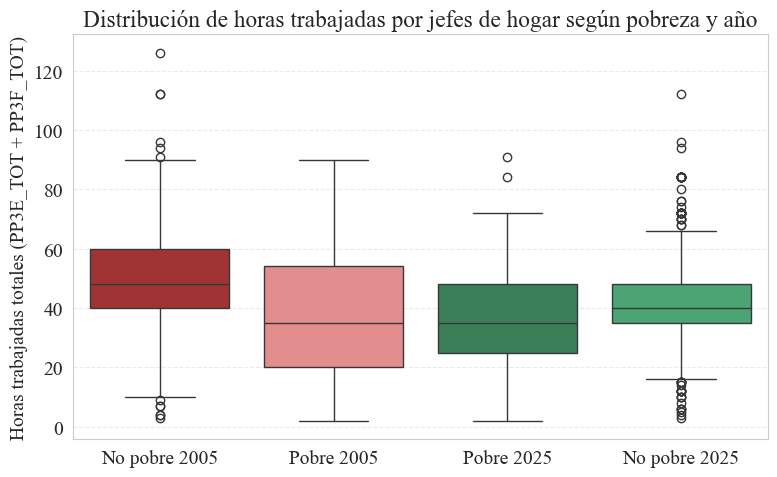

In [127]:
# ================================
# 1️⃣ Filtrar base: excluir ITF = 0 y jefes con horas válidas
# ================================
jefes = base[
    (base["es_jefe"] == 1) & # se filtra la base para jefes de hogar
    (base["horastrab"].notna()) & # horas trabajadas no nulas
    (base["ITF"] > 0) & # ingreso total familiar positivo
    (base["horastrab"] > 0) # horas trabajadas positivas
].copy()

# ================================
# 2️⃣ Crear variable de grupo (pobreza + año)
# ================================
jefes.loc[(jefes["ANO4"] == 2005) & (jefes["pobre"] == 1), "grupo_pobreza_anio"] = "Pobre 2005"
jefes.loc[(jefes["ANO4"] == 2005) & (jefes["pobre"] == 0), "grupo_pobreza_anio"] = "No pobre 2005"
jefes.loc[(jefes["ANO4"] == 2025) & (jefes["pobre"] == 1), "grupo_pobreza_anio"] = "Pobre 2025"
jefes.loc[(jefes["ANO4"] == 2025) & (jefes["pobre"] == 0), "grupo_pobreza_anio"] = "No pobre 2025"

# ================================
# 3️⃣ Boxplot de horas trabajadas
# ================================
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=jefes,
    x="grupo_pobreza_anio",
    y="horastrab",
    palette=["firebrick", "lightcoral", "seagreen", "mediumseagreen"]
)
plt.title("Distribución de horas trabajadas por jefes de hogar según pobreza y año")
plt.xlabel("")
plt.ylabel("Horas trabajadas totales (PP3E_TOT + PP3F_TOT)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


### Consigna 5 

In [128]:
tabla_resumen = pd.DataFrame(index=["2005", "2025", "Total"], 
                             columns=[
                                 "Cantidad observaciones",
                                 "Cantidad de observaciones con NAs en 'Pobre'",
                                 "Cantidad de Pobres",
                                 "Cantidad de No Pobres",
                                 "Cantidad de variables limpias y homogeneizadas"
                             ])

for año in [2005, 2025]:
    base_año = base[base["ANO4"] == año]
    
    total_obs = len(base_año)
    na_pobre = base_año["pobre"].isna().sum()
    pobres = (base_año["pobre"] == 1).sum()
    no_pobres = (base_año["pobre"] == 0).sum()
    vars_limpias = base_año.shape[1]
    
    tabla_resumen.loc[str(año)] = [total_obs, na_pobre, pobres, no_pobres, vars_limpias]

# Totales generales
total_obs = len(base)
na_pobre = base["pobre"].isna().sum()
pobres = (base["pobre"] == 1).sum()
no_pobres = (base["pobre"] == 0).sum()
vars_limpias = base.shape[1]

tabla_resumen.loc["Total"] = [total_obs, na_pobre, pobres, no_pobres, vars_limpias]

# Mostrar tabla final
print("\n📋 Tabla 1. Resumen de la base final para la región YYY")
print(tabla_resumen)


del  tabla_resumen, na_pobre, pobres, no_pobres, total_obs, vars_limpias, base_año, año


📋 Tabla 1. Resumen de la base final para la región YYY
      Cantidad observaciones Cantidad de observaciones con NAs en 'Pobre'  \
2005                    3229                                            0   
2025                    5359                                            0   
Total                   8588                                            0   

      Cantidad de Pobres Cantidad de No Pobres  \
2005                 623                  2606   
2025                2136                  3223   
Total               2759                  5829   

      Cantidad de variables limpias y homogeneizadas  
2005                                              43  
2025                                              43  
Total                                             43  
